# 图像分割
1. 下载数据集
2. 定义模型
3. 训练模型
4. 做出预测


图像分割的任务是训练一个神经网络来输出该图像对每一个像素的掩码。这对从更底层，即像素层级，来理解图像很有帮助。图像分割在例如医疗图像、自动驾驶车辆以及卫星图像等领域有很多应用。

----------------------------


本教程将使用的数据集是 Oxford-IIIT Pet 数据集，由 Parkhi et al. 创建。该数据集由图像、图像所对应的标签、以及对像素逐一标记的掩码组成。掩码其实就是给每个像素的标签。每个像素分别属于以下三个类别中的一个：


*   类别 1：像素是宠物的一部分。
*   类别 2：像素是宠物的轮廓。
*   类别 3：以上都不是/外围像素。



In [19]:
pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ekafnk9f
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ekafnk9f


In [20]:
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [21]:
# 下载数据集
dataset,info = tfds.load('oxford_iiit_pet:3.*.*',with_info=True)

In [22]:
# 下面的代码进行了一个简单的图像翻转扩充。
# 然后，将图像标准化到 [0,1]。
# 最后，如上文提到的，像素点在图像分割掩码中被标记为 {1, 2, 3} 中的一个。
# 为了方便起见，我们将分割掩码都减 1，得到了以下的标签：{0, 1, 2}。

def normalize(input_image,input_mask):
  input_image = tf.cast(input_image,tf.float32)/225.0
  #分割掩码都减 1，得到了以下的标签：{0, 1, 2}。
  input_mask -= 1
  return input_image,input_mask


In [23]:
# @tf.function
# def load_image_train(datapoint):
#   input_image = tf.image.resize(datapoint['image'],(128,128))
#   input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))


#   if tf.random.uniform(())>0.5:
#     # 翻转扩充
#     input_image = tf.image.flip_left_right(input_image)
#     input_mask = tf.image.flip_left_right(input_mask)
  
#   input_image,input_mask = normalize(input_image,input_mask)

#   return input_image,input_mask

In [24]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))

  input_image,input_mask = normalize(input_image,input_mask)
  return input_image,input_mask


In [25]:
# 划分数据集
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH #batch size

In [26]:
# train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test = dataset['test'].map(load_image_test)

In [27]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

下面的类通过随机翻转图像来执行简单的增强

In [28]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [29]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

構建流水線，在對輸入進行批處理後應用增強


In [30]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [31]:
# 查看数据集中的一例图像以及对应掩码
def display(display_list):
  plt.figure(figsize=(15,15))

  title =['Input Image','True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

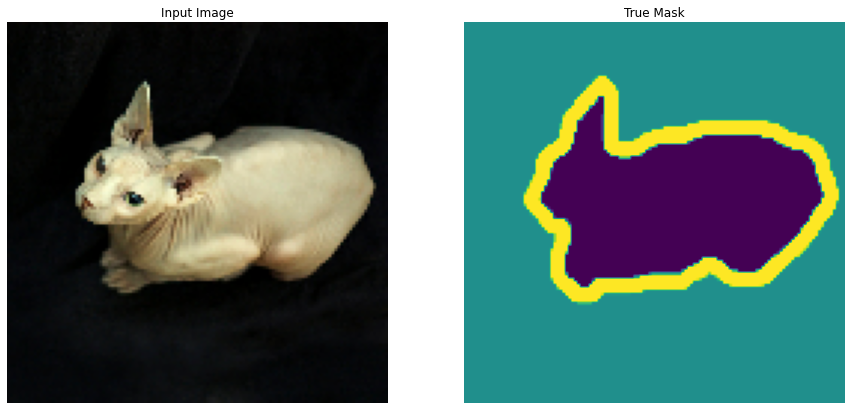

In [32]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

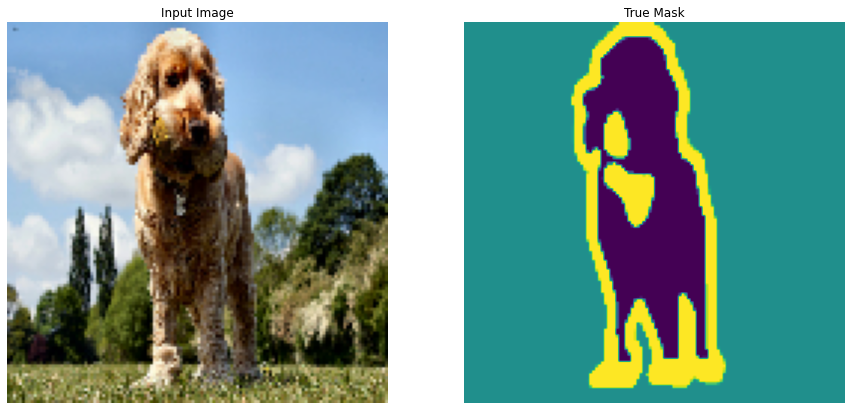

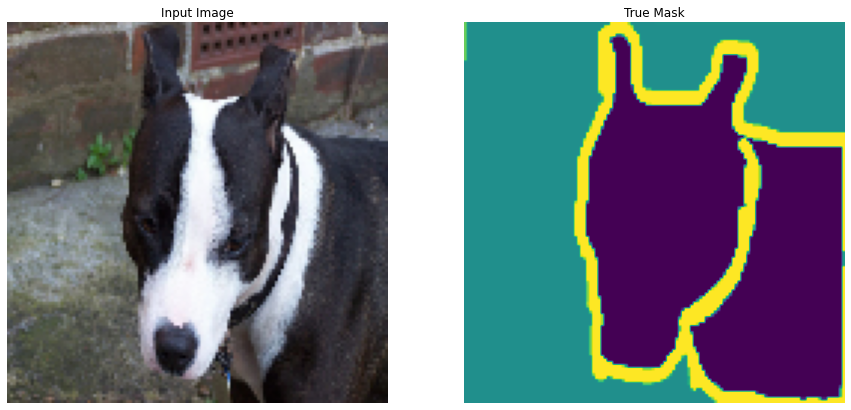

In [33]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# 定义模型

1. 这里用到的模型是一个改版的 U-Net。U-Net 由一个编码器（下采样器（downsampler））和一个解码器（上采样器（upsampler））组成。


2. 为了学习到鲁棒的特征，同时减少可训练参数的数量，这里可以使用一个预训练模型作为编码器。因此，这项任务中的编码器将使用一个预训练的 MobileNetV2 模型，它的中间输出值将被使用。解码器将使用在 TensorFlow Examples 中的 Pix2pix tutorial 里实施过的升频取样模块。


3. 输出信道数量为 3 是因为每个像素有三种可能的标签。把这想象成一个多类别分类，每个像素都将被分到三个类别当中。

In [34]:
OUT_CHANNELS = 3


之前提到的，编码器是一个预训练的 MobileNetV2 模型，它在 tf.keras.applications 中已被准备好并可以直接使用。编码器中包含模型中间层的一些特定输出。注意编码器在模型的训练过程中是不会被训练的。




In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

In [36]:
# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]



In [37]:
layers = [base_model.get_layer(name).output for name in layer_names]

In [38]:
# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input,outputs=layers)
down_stack.trainble=False

解码器/升频取样器是简单的一系列升频取样模块，在 TensorFlow examples 中曾被实施过。

In [39]:
up_stack = [
    pix2pix.upsample(512,3),
    pix2pix.upsample(256,3),
    pix2pix.upsample(128,3),
    pix2pix.upsample(64,3),
    
]

In [40]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 在模型中降频取样
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 升频取样然后建立跳跃连接
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 这是模型的最后一层
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# 訓練模型
现在，要做的只剩下编译和训练模型了。这里用到的损失函数是 losses.sparse_categorical_crossentropy。使用这个损失函数是因为神经网络试图给每一个像素分配一个标签，和多类别预测是一样的。

In [41]:
# 训练模型
model = unet_model(OUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


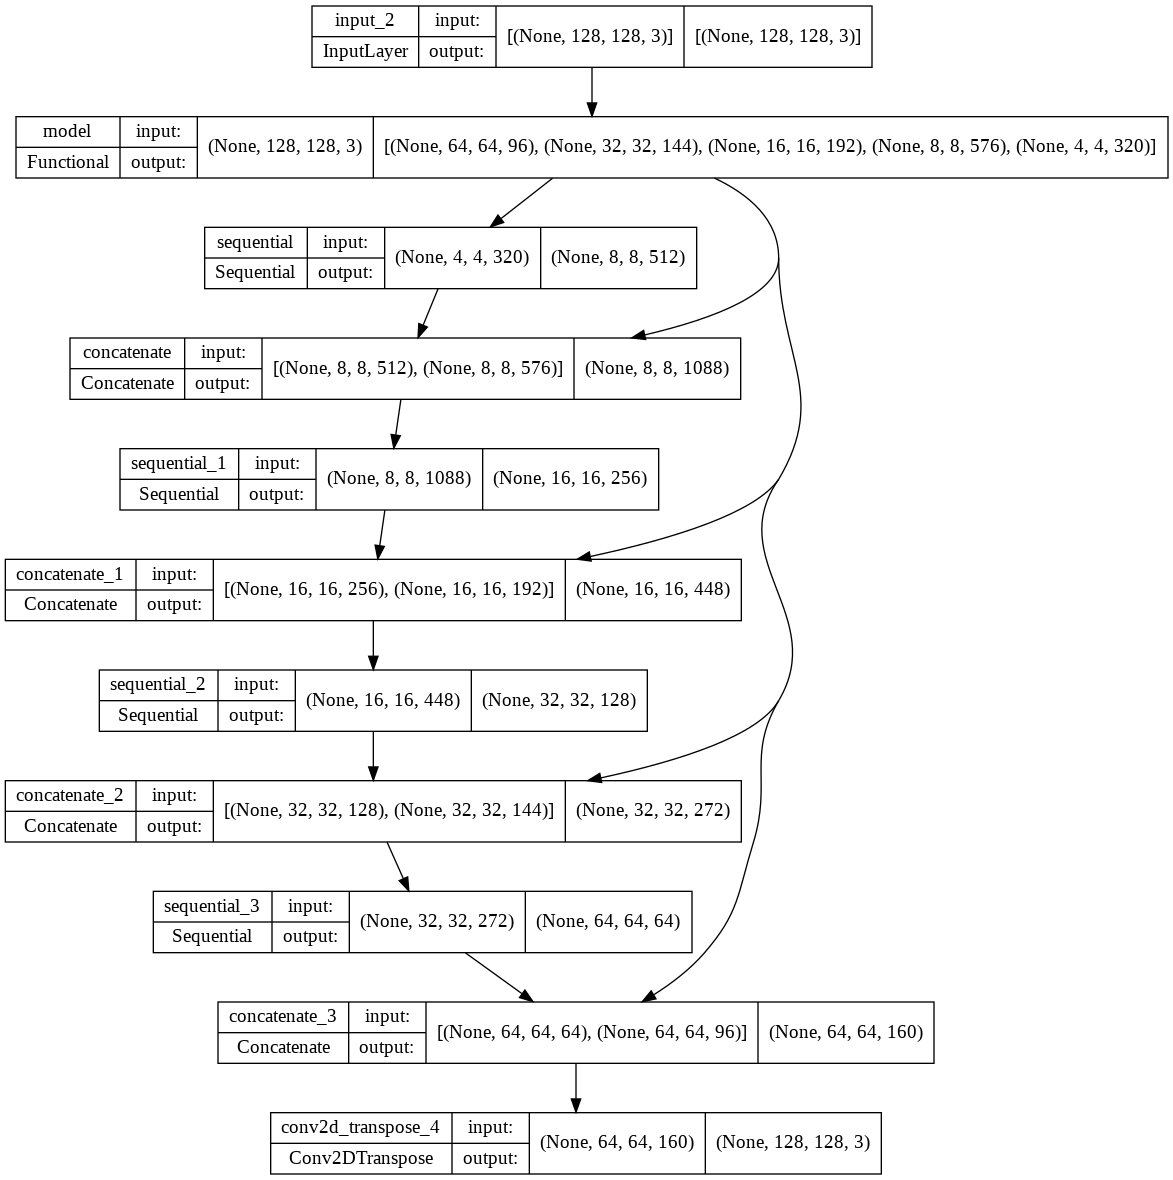

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

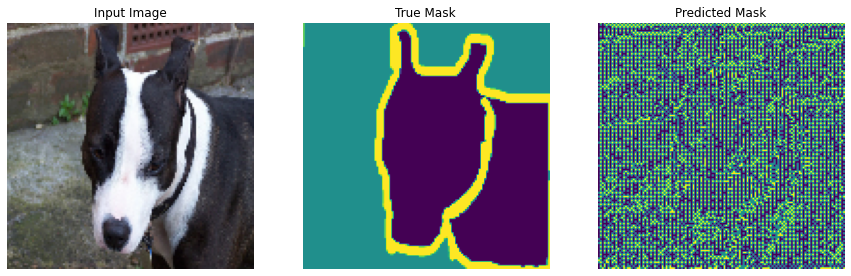

In [44]:
show_predictions()

我们来观察模型是怎样随着训练而改善的。为达成这一目的，下面将定义一个 callback 函数。

In [45]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSample Prediction after epoch {}\n".format(epoch+1))


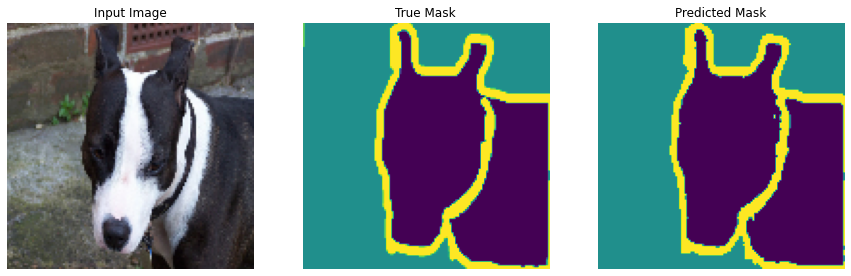


Sample Prediction after epoch 5

3680/3680 [==============================] - 860s 234ms/step - loss: 0.0170 - accuracy: 0.9782 - val_loss: 0.9595 - val_accuracy: 0.8983


In [46]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

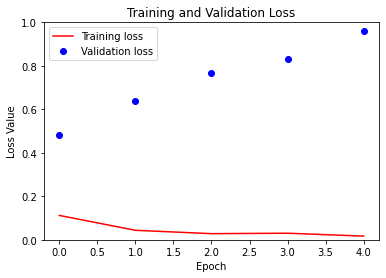

In [47]:
# 可视化
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

做预测

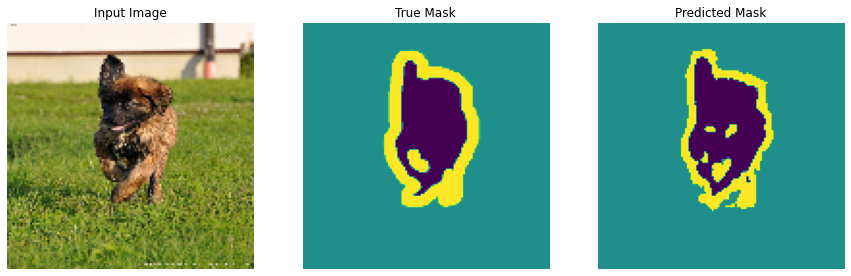

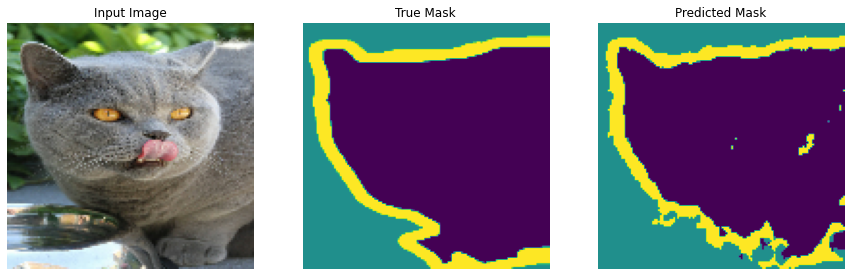

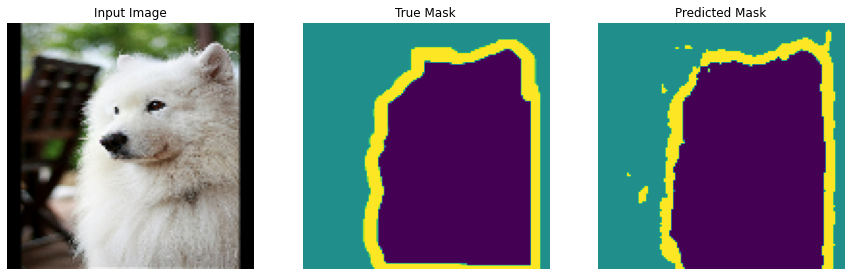

In [48]:
show_predictions(test_dataset, 3)